In [ ]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [ ]:
#Database connection
connect_ = sqlite3.connect('/content/TechPro-DataScience-Midseason-Dataset.db')

In [ ]:
#I retrieve the names of all tables from the database and print them
cursor = connect_.cursor()

cursor.execute('SELECT name FROM sqlite_master WHERE type="table";')
tables = cursor.fetchall()
print('My table : ')
for t in tables:
    print(t[0])

My table : 
houses
cities
energy_classes


In [ ]:
#For each table, we display its columns and data types.
tables = ['houses', 'cities', 'energy_classes']

for t in tables:
    print(f'\n My table with column is: {t}')
    cursor.execute(f'PRAGMA table_info({t});')
    for c in cursor.fetchall():
      #I Print the name and data type of each column
        print(f' - {c[1]} ({c[2]})')


 My table with column is: houses
 - uuid (TEXT)
 - Area (REAL)
 - Bedrooms (REAL)
 - Bathrooms (REAL)
 - Floor (REAL)
 - Year Built (TEXT)
 - City (TEXT)
 - Energy Class (TEXT)
 - Price (REAL)

 My table with column is: cities
 - index (TEXT)
 - Crime (REAL)

 My table with column is: energy_classes
 - index (TEXT)
 - Tax Rate (REAL)


In [ ]:
#Sql query to retrieve data from the tables houses, cities, energy_classes

from sqlite3.dbapi2 import connect

my_query_ = """
SELECT
    h.Area,
    h.Bedrooms,
    h.Bathrooms,
    h.'Energy Class',
    h.'Year Built',
    h.Price,
    h.'City',
    c.Crime,
    e.'Tax Rate'
FROM houses as h
JOIN cities as c ON h.City = c.'index'
JOIN energy_classes as e ON h.'Energy Class' = e.'index';
"""
#Execute the query in the database

cursor.execute(my_query_)

#Retrieve all results
rows = cursor.fetchall()

#List of column names from the query result
columns = [i[0] for i in cursor.description]

#I Create DataFrame from the results
data = pd.DataFrame(rows, columns=columns)

#Close the database connection
connect_.close()

#Print the first five rows
print(data.head())

    Area  Bedrooms  Bathrooms Energy Class Year Built     Price     City  \
0   86.0       3.0        NaN            A     1979.0  112000.0   Athens   
1   49.0       1.0        1.0            C     2003.0   39000.0    Lamia   
2  106.0       5.0        5.0            E     1956.0   78000.0  Larissa   
3   95.0       3.0        3.0            A     1957.0  106000.0   Athens   
4   55.0       3.0        4.0            A     2012.0   99000.0   Athens   

      Crime  Tax Rate  
0 -1.625270      0.05  
1  0.343085      0.10  
2 -0.689243      0.19  
3 -1.625270      0.05  
4 -1.625270      0.05  


In [ ]:
#Check how many duplicate have in my dataset
data.duplicated().sum()

np.int64(2)

In [ ]:
#Revome duplicate
data = data.drop_duplicates()

In [ ]:
#Check how many missing values exist in dataset
missing_value = data.isna().sum()

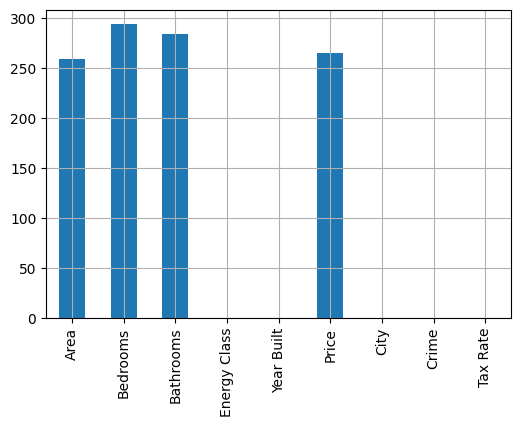

In [ ]:
missing_value.plot(kind='bar', figsize=(6, 4))
plt.grid(True)
plt.show()

In [ ]:
#Check unique values in column 'City'
data['City'].unique()

array(['Athens', 'Lamia', 'Larissa', 'Thessaloniki', 'Trikala', 'Crete',
       'Thebes'], dtype=object)

In [ ]:
#One-hot encoding for the 'City' column, removing the first category
data_dummies = pd.get_dummies(data['City'], drop_first=True).astype(int)

In [ ]:
#Remove column 'City'
data = pd.concat([data.drop('City', axis=1), data_dummies], axis=1)

In [ ]:
data.head()

,Area,Bedrooms,Bathrooms,Energy Class,Year Built,Price,Crime,Tax Rate,Crete,Lamia,Larissa,Thebes,Thessaloniki,Trikala
0,86.0,3.0,NaN,A,1979.0,112000.0,-1.625270,0.05,0,0,0,0,0,0
1,49.0,1.0,1.0,C,2003.0,39000.0,0.343085,0.10,0,1,0,0,0,0
2,106.0,5.0,5.0,E,1956.0,78000.0,-0.689243,0.19,0,0,1,0,0,0
3,95.0,3.0,3.0,A,1957.0,106000.0,-1.625270,0.05,0,0,0,0,0,0
4,55.0,3.0,4.0,A,2012.0,99000.0,-1.625270,0.05,0,0,0,0,0,0


In [ ]:
#Check unique values for the column 'Energy Class'
data['Energy Class'].unique()

array(['A', 'C', 'E', 'B', 'D'], dtype=object)

In [ ]:
#Convert to a categorical variable, from which energy class is better quality to those with the lowest quality
energy_ = {
    'A': 5,
    'B': 4,
    'C': 3,
    'D': 2,
    'E': 1
}

data['Energy Class'] = data['Energy Class'].map(energy_)

In [ ]:
#chech my dataset again
data.head()

,Area,Bedrooms,Bathrooms,Energy Class,Year Built,Price,Crime,Tax Rate,Crete,Lamia,Larissa,Thebes,Thessaloniki,Trikala
0,86.0,3.0,NaN,5,1979.0,112000.0,-1.625270,0.05,0,0,0,0,0,0
1,49.0,1.0,1.0,3,2003.0,39000.0,0.343085,0.10,0,1,0,0,0,0
2,106.0,5.0,5.0,1,1956.0,78000.0,-0.689243,0.19,0,0,1,0,0,0
3,95.0,3.0,3.0,5,1957.0,106000.0,-1.625270,0.05,0,0,0,0,0,0
4,55.0,3.0,4.0,5,2012.0,99000.0,-1.625270,0.05,0,0,0,0,0,0


<Axes: >

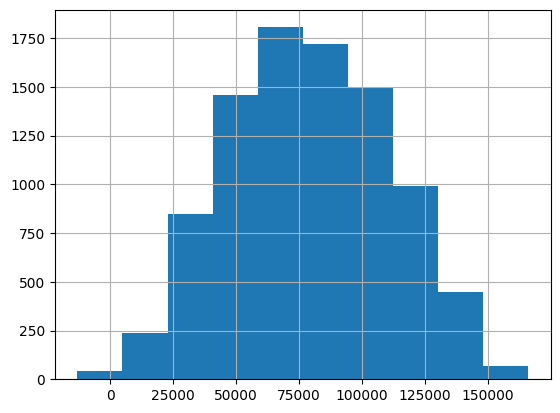

In [ ]:
#I choose a histogram for graph to see the distribution
data['Price'].hist()

<Axes: ylabel='Price'>

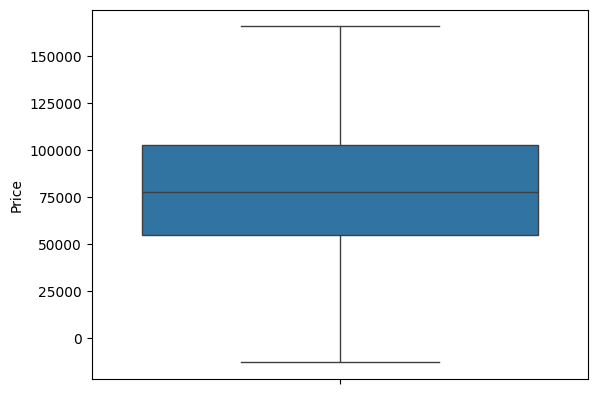

In [ ]:
#I choose boxplot for graphs to see some statistics of the column that I will use for prediction.
sns.boxplot(data=data['Price'])

In [ ]:
#Because I have negative values ​​in the price of houses, I make a mask where I will have the data filtered to be above 0.
data = data[data['Price'] > 0]

In [ ]:
#statistics
data.describe()

,Area,Bedrooms,Bathrooms,Energy Class,Price,Crime,Tax Rate,Crete,Lamia,Larissa,Thebes,Thessaloniki,Trikala
count,8835.000000,8797.000000,8815.000000,9085.000000,9085.000000,9085.000000,9085.000000,9085.000000,9085.000000,9085.000000,9085.000000,9085.000000,9085.000000
mean,77.047878,3.083324,3.335111,3.019042,79167.088608,-0.374831,0.109370,0.129334,0.054155,0.063181,0.063621,0.248321,0.061420
std,24.335113,1.290198,1.328762,1.416769,31815.207640,1.164614,0.050123,0.335588,0.226336,0.243302,0.244091,0.432063,0.240112
min,35.000000,1.000000,1.000000,1.000000,1000.000000,-1.625270,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,2.000000,2.000000,2.000000,55000.000000,-1.625270,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,77.000000,3.000000,3.000000,3.000000,78000.000000,-0.689243,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98.000000,4.000000,5.000000,4.000000,103000.000000,0.453732,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,119.000000,5.000000,5.000000,5.000000,166000.000000,1.472769,0.190000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data_columns = data[[i for i in data.columns if i != 'Price']]

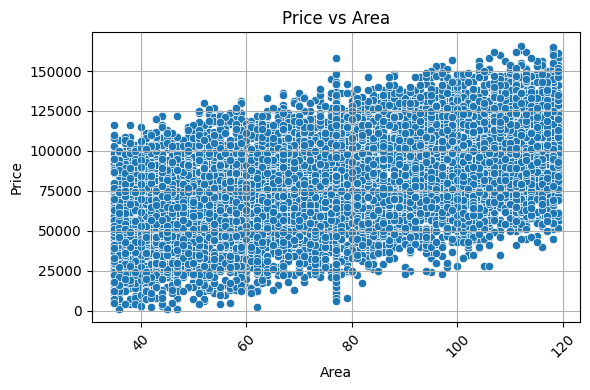

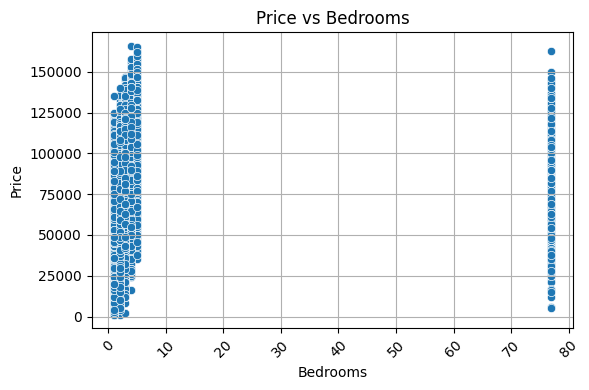

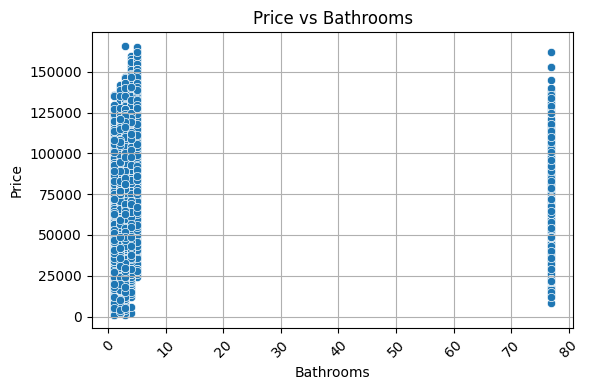

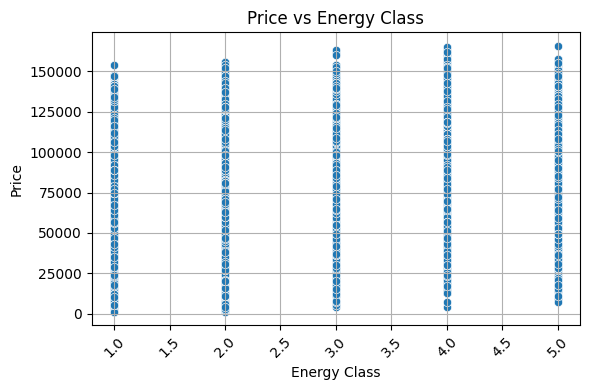

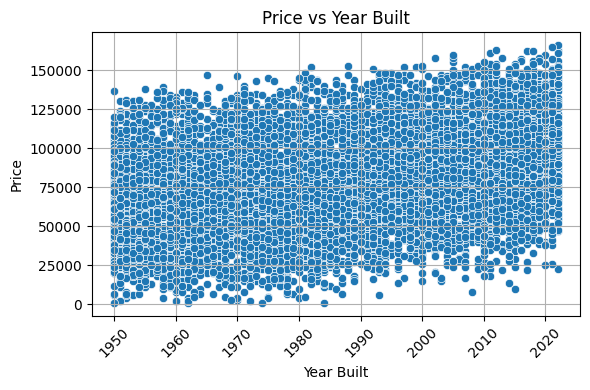

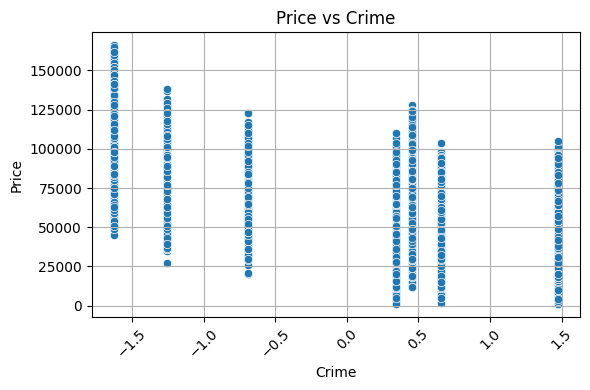

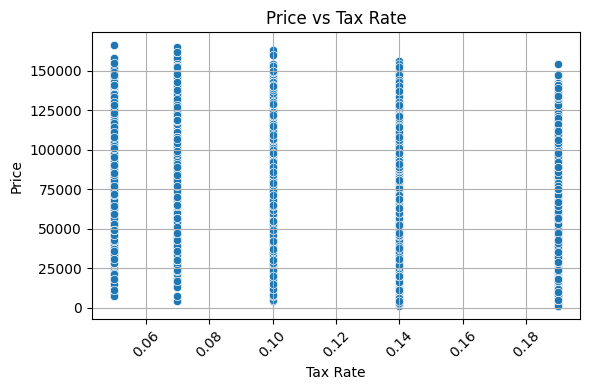

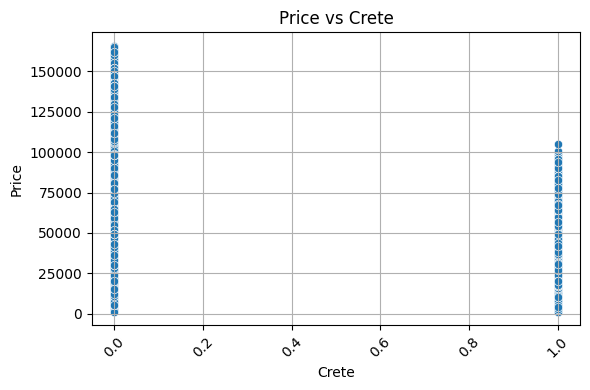

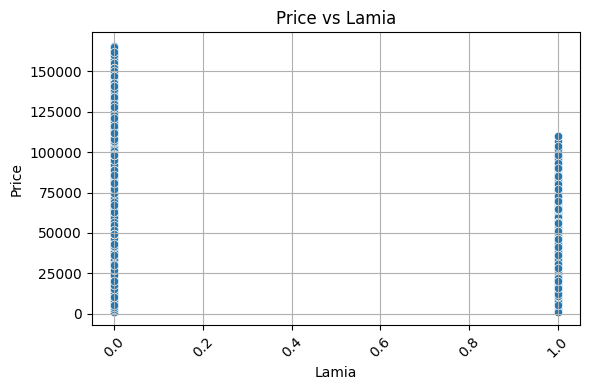

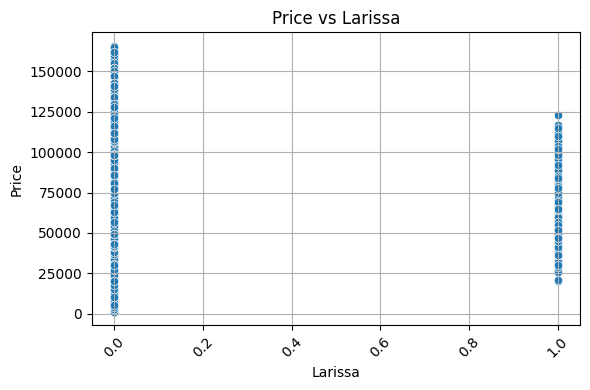

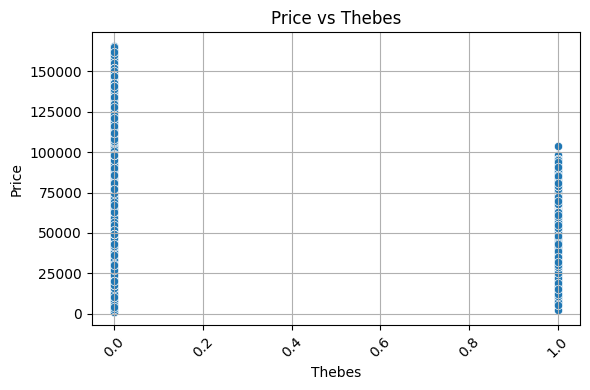

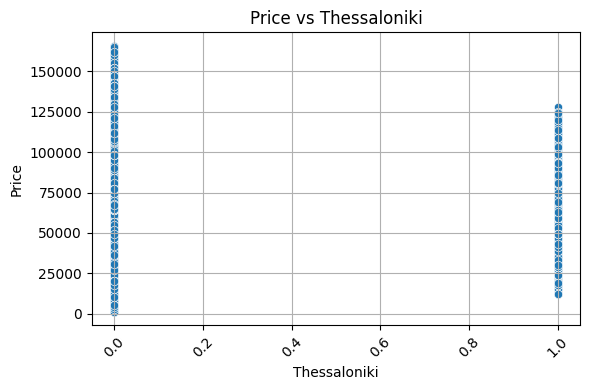

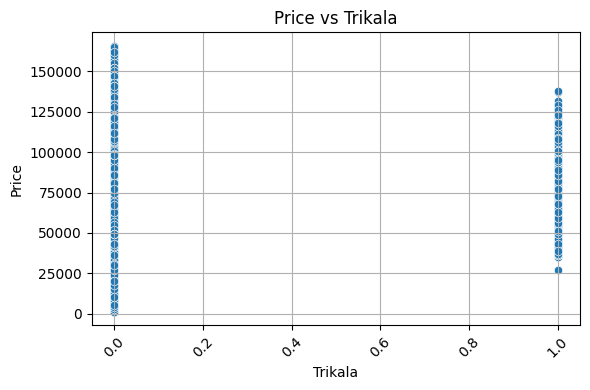

In [ ]:
#I'm creating a graph to see how much the cost of a house is affected by column
for col in data_columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=data, x=col, y='Price')
    plt.title(f'Price vs {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [ ]:
#I remove all nan from the prediction column
data = data.dropna(subset=['Price'])

In [ ]:
#I put the median in the nan of the columns
for i in ['Area', 'Bedrooms', 'Bathrooms']:
  data.fillna(data[i].median(), inplace=True)

In [ ]:
#chech information again
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9085 entries, 0 to 9376
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          9085 non-null   float64
 1   Bedrooms      9085 non-null   float64
 2   Bathrooms     9085 non-null   float64
 3   Energy Class  9085 non-null   int64  
 4   Year Built    9085 non-null   object 
 5   Price         9085 non-null   float64
 6   Crime         9085 non-null   float64
 7   Tax Rate      9085 non-null   float64
 8   Crete         9085 non-null   int64  
 9   Lamia         9085 non-null   int64  
 10  Larissa       9085 non-null   int64  
 11  Thebes        9085 non-null   int64  
 12  Thessaloniki  9085 non-null   int64  
 13  Trikala       9085 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [ ]:
len(data[data['Year Built'] == 'nan'])

256

In [ ]:
#check unique values
data['Year Built'].unique()

array(['1979.0', '2003.0', '1956.0', '1957.0', '2012.0', '2013.0',
       '1959.0', '2018.0', '1998.0', '1988.0', '1983.0', '1958.0',
       '2009.0', '1954.0', '1960.0', '1991.0', '1969.0', '2000.0',
       '1950.0', '2010.0', '1977.0', '1985.0', '2011.0', '2019.0',
       '2008.0', '1973.0', '1965.0', '1995.0', '1970.0', 'nan', '1990.0',
       '2015.0', '1972.0', '1952.0', '2002.0', '1976.0', '1971.0',
       '1993.0', '1951.0', '2016.0', '1963.0', '2001.0', '2006.0',
       '1994.0', '1978.0', '1981.0', '1953.0', '1964.0', '1996.0',
       '1955.0', '2020.0', '1961.0', '2014.0', '1982.0', '2021.0',
       '2022.0', '1992.0', '1967.0', '1980.0', '1986.0', '2007.0',
       '1997.0', '1962.0', '1999.0', '1966.0', '1989.0', '2004.0',
       '1968.0', '1975.0', '1974.0', '1987.0', '2017.0', '1984.0',
       '2005.0'], dtype=object)

In [ ]:
#convert from str nan to regular nan
data['Year Built'] = data['Year Built'].replace('nan', np.nan)

In [ ]:
#change type
data['Year Built'] = data['Year Built'].astype(float)

In [ ]:
#change type again
data['Year Built'] = data['Year Built'].astype('Int64')

In [ ]:
#chech nan
data['Year Built'].isna().sum()

np.int64(256)

In [ ]:
#revome nan
data = data.dropna(subset=['Year Built'])

In [ ]:
#chech correlation columns
correlation_column = data.corr()
correlation_column

,Area,Bedrooms,Bathrooms,Energy Class,Year Built,Price,Crime,Tax Rate,Crete,Lamia,Larissa,Thebes,Thessaloniki,Trikala
Area,1.000000,0.097951,0.065653,-0.005889,0.015290,0.479711,-0.017457,0.006546,-0.009229,-0.020723,0.002621,-0.014291,0.004695,0.018635
Bedrooms,0.097951,1.000000,0.030174,-0.001004,0.014317,0.031764,0.019932,0.004863,-0.001689,0.012252,0.011864,0.007540,0.015001,-0.009853
Bathrooms,0.065653,0.030174,1.000000,0.001440,-0.008365,0.019718,0.009174,-0.002401,0.010157,-0.006774,0.004774,-0.010398,0.008840,-0.001160
Energy Class,-0.005889,-0.001004,0.001440,1.000000,-0.005770,0.170604,0.009692,-0.986020,-0.002064,-0.008086,-0.009049,0.018833,0.010460,-0.008730
Year Built,0.015290,0.014317,-0.008365,-0.005770,1.000000,0.296154,0.001199,0.005450,0.004590,-0.003125,-0.009363,0.007396,-0.004991,0.005936
Price,0.479711,0.031764,0.019718,0.170604,0.296154,1.000000,-0.728253,-0.177140,-0.405270,-0.188518,-0.063207,-0.218443,-0.232879,0.026892
Crime,-0.017457,0.019932,0.009174,0.009692,0.001199,-0.728253,1.000000,-0.009572,0.611676,0.147750,-0.070092,0.230730,0.409120,-0.194117
Tax Rate,0.006546,0.004863,-0.002401,-0.986020,0.005450,-0.177140,-0.009572,1.000000,0.004152,0.006796,0.005336,-0.019235,-0.011069,0.010573
Crete,-0.009229,-0.001689,0.010157,-0.002064,0.004590,-0.405270,0.611676,0.004152,1.000000,-0.092316,-0.100209,-0.100209,-0.221508,-0.098572
Lamia,-0.020723,0.012252,-0.006774,-0.008086,-0.003125,-0.188518,0.147750,0.006796,-0.092316,1.000000,-0.062270,-0.062270,-0.137645,-0.061253


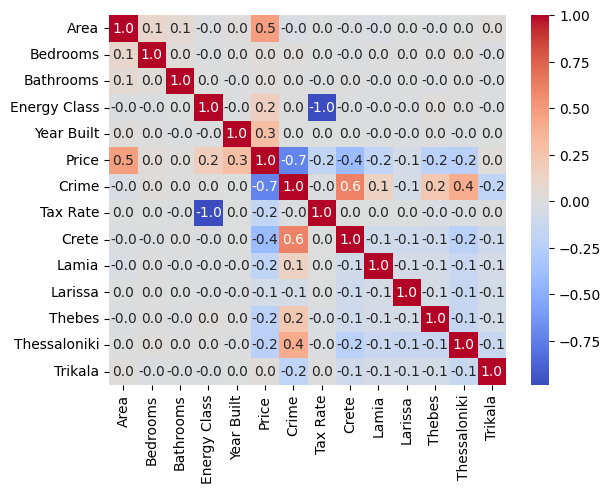

In [ ]:
#graph for i see correlation
sns.heatmap(correlation_column, annot=True,cmap='coolwarm', fmt=".1f")
plt.show()

In [ ]:
# Remove the value and keep the attributes , I define the value as the target variable
x_ = data.drop(['Price'],axis=1)
y_ = data['Price']

In [ ]:
def evaluate_models_(x, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold = 1
    for i_train, i_test in kf.split(x):
        print(f'\n Fold {fold}')

        x_train, x_test = x.iloc[i_train], x.iloc[i_test]
        y_train, y_test = y.iloc[i_train], y.iloc[i_test]

        #Scaling (z score)
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        #Linear Regression model
        lr_model = LinearRegression()
        lr_model.fit(x_train_scaled, y_train)
        pred_test = lr_model.predict(x_test_scaled)
        pred_train = lr_model.predict(x_train_scaled)

        rmse_train_lr = np.sqrt(mean_squared_error(y_train, pred_train))
        rmse_test_lr = np.sqrt(mean_squared_error(y_test, pred_test))

        print('R2 score test linear model:', r2_score(y_test, pred_test))
        print('RMSE test linear model :',rmse_test_lr )
        print('R2 skore train linear model:', r2_score(y_train, pred_train))
        print('RMSE train linear model:',rmse_train_lr )


        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        #create DecisionTreeRegressor model
        tree_model = DecisionTreeRegressor(max_depth=6, min_samples_split=8)
        tree_model.fit(x_train, y_train)
        pred_test_tree = tree_model.predict(x_test)
        pred_train_tree = tree_model.predict(x_train)

        rmse_train_tree = np.sqrt(mean_squared_error(y_train, pred_train_tree))
        rmse_test_tree = np.sqrt(mean_squared_error(y_test, pred_test_tree))

        print('R2 score test:', r2_score(y_test, pred_test_tree))
        print('RMSE test:', rmse_test_tree)
        print('R2 score train:', r2_score(y_train, pred_train_tree))
        print('RMSE train:',rmse_train_tree)


        if fold == n_splits:
            return y_test, pred_test, pred_test_tree, rmse_train_lr, rmse_test_lr, rmse_train_tree, rmse_test_tree

        fold += 1

In [ ]:
y_actual, y_pred_lr, y_pred_tree, rmse_train_lr, rmse_test_lr, rmse_train_tree, rmse_test_tree = evaluate_models_(x_, y_)


 Fold 1
R2 score test linear model: 0.9038473509447879
RMSE test linear model : 9944.096308954826
R2 skore train linear model: 0.9116974989183401
RMSE train linear model: 9447.128109670564
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2 score test: 0.8480319526868962
RMSE test: 12501.462902734595
R2 score train: 0.8652270280963691
RMSE train: 11671.178331187963

 Fold 2
R2 score test linear model: 0.9229457822177677
RMSE test linear model : 9109.442168258876
R2 skore train linear model: 0.9094513455566352
RMSE train linear model: 9540.453290887408
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2 score test: 0.8685104495114191
RMSE test: 11899.787206905785
R2 score train: 0.8611107289310526
RMSE train: 11815.778971934753

 Fold 3
R2 score test linear model: 0.9105069949609689
RMSE test linear model : 9452.361503419881
R2 skore train linear model: 0.9109389403778778
RMSE train linear model: 9503.603229908682
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2 score test: 0.849625594

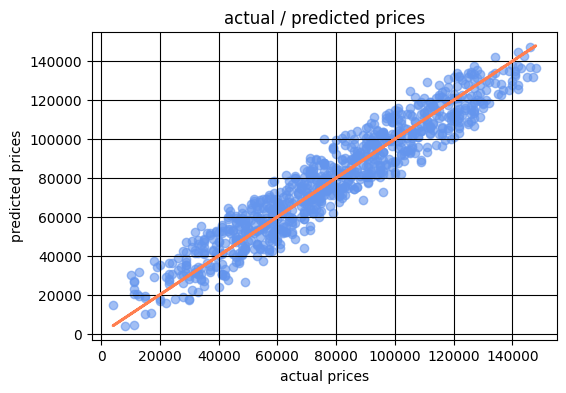

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_actual, y_pred_lr, color='cornflowerblue', alpha=0.6)
plt.plot(y_actual, y_actual, color='coral', linewidth=2)
plt.xlabel('actual prices')
plt.ylabel('predicted prices')
plt.title('actual / predicted prices')
plt.grid(True,color='black')
plt.show()

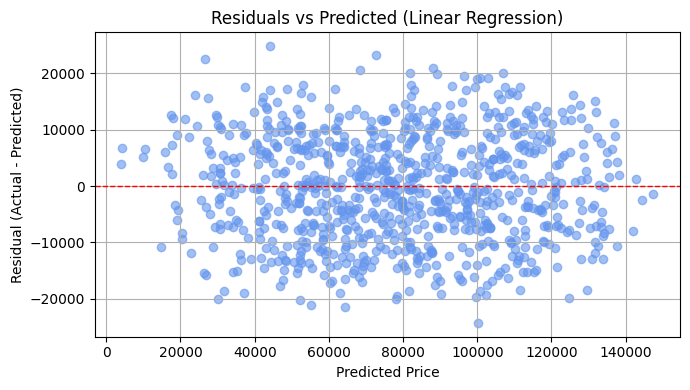

In [ ]:
#Residuals vs Predicted
residuals = y_actual - y_pred_lr

plt.figure(figsize=(7, 4))
plt.scatter(y_pred_lr, residuals, alpha=0.6, color='cornflowerblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted (Linear Regression)')
plt.grid(True)
plt.tight_layout()
plt.show()

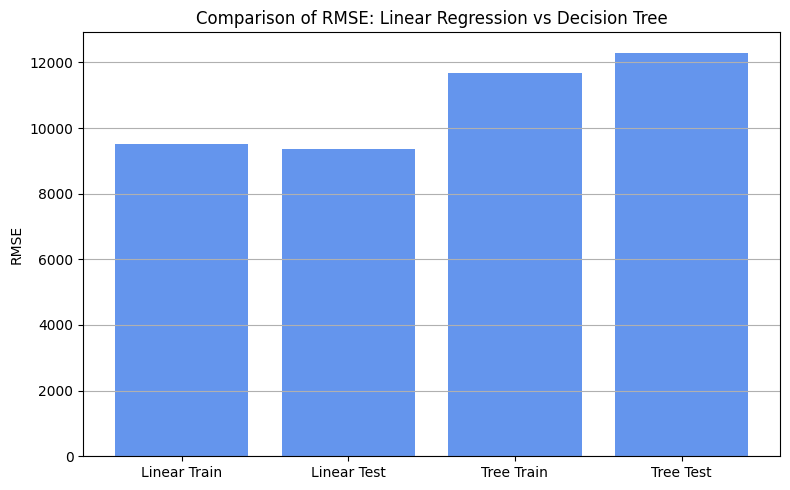

In [ ]:
# we see if Linear Regression or Decision Tree has smaller errors
labels = ['Linear Train', 'Linear Test', 'Tree Train', 'Tree Test']
rmse_values = [rmse_train_lr, rmse_test_lr, rmse_train_tree, rmse_test_tree]

plt.figure(figsize=(8, 5))
plt.bar(labels, rmse_values, color='cornflowerblue')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE: Linear Regression vs Decision Tree')
plt.grid(axis='y')
plt.tight_layout()
plt.show()